<a href="https://colab.research.google.com/github/AbhiNene/credit-card-fraud-detection/blob/main/creditcardfrauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Logistic Regression Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12001
           1       0.26      0.86      0.40        98

    accuracy                           0.98     12099
   macro avg       0.63      0.92      0.70     12099
weighted avg       0.99      0.98      0.98     12099

ROC-AUC: 0.9597733352152626

Random Forest Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12001
           1       0.91      0.79      0.84        98

    accuracy                           1.00     12099
   macro avg       0.95      0.89      0.92     12099
weighted avg       1.00      1.00      1.00     12099

ROC-AUC RF: 0.9661954190892255


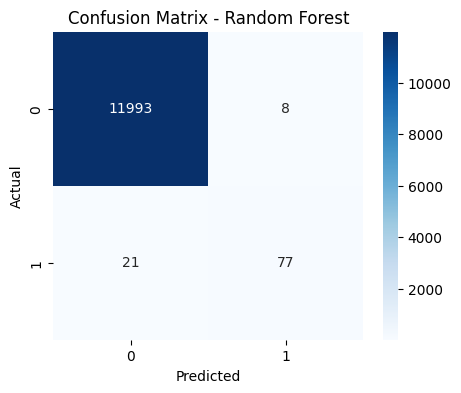

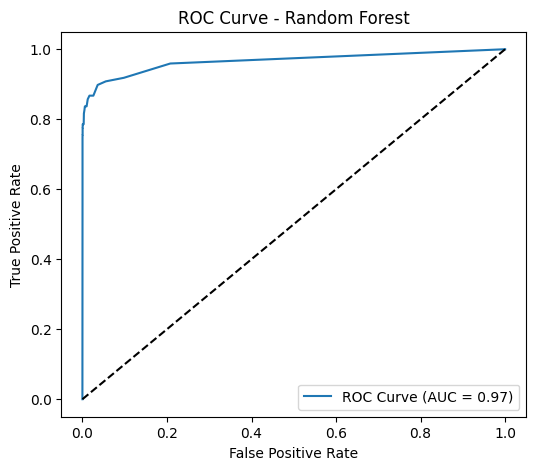

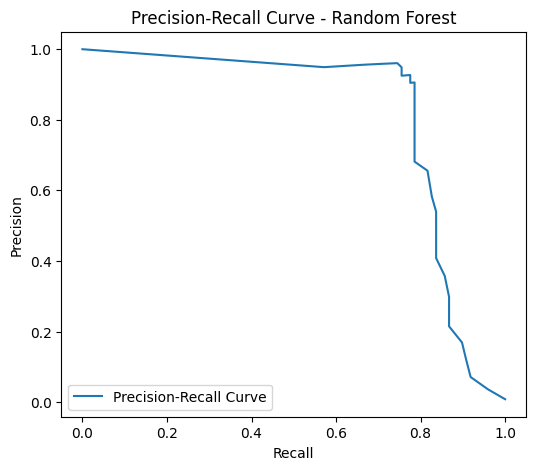

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None, 'class_weight': 'balanced'}
Best ROC-AUC: 0.99999926923598


In [ ]:
# -------------------
# 1. Libraries
# -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTEENN

# -------------------
# 2. Load & Preprocess
# -------------------
df = pd.read_csv('creditcard.csv')

# Scale 'Amount'
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df = df.drop(['Amount', 'Time'], axis=1)

X = df.drop('Class', axis=1)
y = df['Class']

# Downsample majority class first (speeds up resampling)
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0].sample(n=min(60000,len(df[df['Class']==0])) , random_state=42)  # from 284k → 60k
df_bal = pd.concat([fraud, non_fraud])

X = df_bal.drop('Class', axis=1)
y = df_bal['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------
# 3. Logistic Regression Baseline
# -------------------
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Report")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

# -------------------
# 4. SMOTEENN + Random Forest
# -------------------
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_res, y_res)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Report")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC RF:", roc_auc_score(y_test, y_prob_rf))

# -------------------
# 5. Visualizations
# -------------------

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.show()

# -------------------
# 6. Hyperparameter Tuning (Optimized RandomizedSearch)
# -------------------
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,       # sample 5 random combos
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_res, y_res)

print("Best Parameters:", random_search.best_params_)
print("Best ROC-AUC:", random_search.best_score_)
